In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [2]:
files = "/home/data_shares/purrlab/physionet.org/files/chexmask-cxr-segmentation-data/0.2"

In [3]:
padchest_masks = pd.read_csv(files+ "/OriginalResolution/Padchest.csv")

/home/caap/.conda/envs/multi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
padchest_masks.head()

,ImageID,Dice RCA (Mean),Dice RCA (Max),Landmarks,Left Lung,Right Lung,Heart,Height,Width
0,216840111366964012487858717522009278090344349_...,0.800701,0.837323,[[1739 368]\n [1534 385]\n [1329 431]\n [11...,1830434 6 1834707 19 1838980 31 1843253 44 184...,1576774 10 1581042 28 1585310 46 1589578 64 15...,5279509 147 5283784 158 5288060 168 5292335 17...,3520.0,4280.0
1,297296042610568106386358000944101882216_oryw2k...,0.82726,0.865835,[[1063 379]\n [ 961 390]\n [ 852 452]\n [ 7...,1084756 8 1087746 22 1090735 37 1093724 52 109...,1138060 6 1141051 18 1144041 31 1147032 43 115...,3853381 77 3856375 96 3859370 113 3862364 132 ...,2667.0,3000.0
2,282304671682231211691601927052092320690_fqq20r...,0.829237,0.871887,[[1182 584]\n [1091 587]\n [ 995 631]\n [ 9...,1614688 7 1617500 21 1620313 33 1623125 47 162...,1645128 17 1647913 51 1650698 85 1653496 106 1...,3680581 68 3683390 80 3686199 92 3689008 104 3...,2624.0,2815.0
3,216840111366964012558082906712010118092605469_...,0.812057,0.836466,[[1576 460]\n [1425 473]\n [1275 544]\n [11...,2005535 154 2009813 160 2014090 166 2018368 17...,1970372 8 1974640 24 1978908 40 1983177 56 198...,7158195 101 7162471 111 7166747 121 7171023 13...,3520.0,4280.0
4,216840111366964012487858717522009264132859659_...,0.802433,0.912305,[[ 649 172]\n [ 589 178]\n [ 523 209]\n [ 4...,271627 5 273282 16 274937 26 276592 36 278247 ...,286166 6 287816 19 289466 33 291116 46 292766 ...,1217632 47 1219272 74 1220920 94 1222578 103 1...,1884.0,1660.0


In [5]:
padchest_df = pd.read_csv("../Data/preprocessed_df.csv", index_col=0)

/home/caap/.conda/envs/multi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
padchest_df.head()

,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,MethodProjection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-1.42,4765777,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]",[],[]
1,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['kyphosis', 'ground glass pattern', 'pseudono...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
2,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,8,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151']
3,313903302629300007485735352869488750471_75sg0k...,0,20170125,313903302629300007485735352869488750471,3707275269754751392247446521222810702,1978.0,M,NaN,AP,Manual review of DICOM fields,...,None,1192,5310833,objet mejori radiolog con practic resolucion ...,Physician,"['interstitial pattern', 'unchanged', 'alveola...","['loc basal', 'loc left']","[['unchanged'], ['alveolar pattern', 'intersti...",['C1332240' 'C2073538'],['C1282378' 'C0443246']
4,3137231742710829928-247610802266403640553_kine...,0,20150804,3137231742710829928-247610802266403640553,93535126770783451980359712286922420997,1957.0,M,NaN,PA,Manual review of DICOM fields,...,0,299,4969767,radiografi actual comp con previ 26 juni pers...,Physician,"['pleural effusion', 'suture material', 'apica...","['loc basal', 'loc subsegmental', 'loc pleural...","[['laminar atelectasis', 'loc subsegmental', '...",['C2073625' 'C4305366' 'C0185792'],['C1282378' 'C0929165' 'C0032225' 'C0444532' '...


In [7]:
test_set = pd.read_csv("../Data/Data_splits/pathology_detection-test.csv", index_col=0)

In [7]:
def remove_lungs(image, mask):
    
    _mask = np.where(mask==0, 1, 0)
    
    return image * _mask

In [8]:
def only_lungs(image, mask):    
    return image * mask

In [9]:
def rle2mask(mask_rle: str, label=1, shape=(3520,4280)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)# Needed to align to RLE direction


def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [10]:
def decode_both_lungs(row, label=1):

    right = rle2mask(
        mask_rle=row["Right Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    )

    left = rle2mask(
        mask_rle=row["Left Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    )

    return right + left

In [11]:
def dilate(image, dilation_rate=1):

    kernel_shape = (dilation_rate*2)+1

    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_shape,kernel_shape))
    dilate = cv2.dilate(image, kernel, iterations=1)

    return dilate

def fast_dilate(image, dilation_rate=1):

    #kernel_shape = (dilation_rate*2)+1

    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    dilate = cv2.dilate(image, kernel, iterations=dilation_rate)

    return dilate


In [12]:
def bounding_box(image, label=1):
    _image = image.copy()
    segmentation = np.where(_image == label)

    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))

    return cv2.rectangle(_image, (x_min, y_min), (x_max, y_max), 1,-1)

In [13]:
def bbox_both_lungs(row, label=1):

    right = bounding_box(rle2mask(
        mask_rle=row["Right Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    ))

    left = bounding_box(rle2mask(
        mask_rle=row["Left Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    ))

    return right + left

In [14]:
def apply_all_augmentations(row, dilation_factor=300000):
    
    dilation_rate = int(np.round((row["Height"] * row["Width"]) / dilation_factor))

    mask = decode_both_lungs(row)
    bbox = bounding_box(mask)
    bbox_both = bbox_both_lungs(row)

    dilated_masks = [fast_dilate(mask, dilation_rate=dilation_rate*(i+1)) for i in range(4)]

    output_row = {
        "ImageID":row["ImageID"],
        "original_mask":mask2rle(mask),
        "bbox_mask":mask2rle(bbox),
        "bbox_both_mask":mask2rle(bbox_both),
        "dilated_mask_1":mask2rle(dilated_masks[0]),
        "dilated_mask_2":mask2rle(dilated_masks[1]),
        "dilated_mask_3":mask2rle(dilated_masks[2]),
        "dilated_mask_4":mask2rle(dilated_masks[3]),
    }

    return output_row

In [15]:
def apply_all_augmentations_no_encode(row, dilation_factor=300000):
    
    dilation_rate = int(np.round((row["Height"] * row["Width"]) / dilation_factor))

    mask = decode_both_lungs(row)
    bbox = bounding_box(mask)
    bbox_both = bbox_both_lungs(row)

    dilated_masks = [fast_dilate(mask, dilation_rate=dilation_rate*(i+1)) for i in range(4)]

    output_row = {
        "ImageID":row["ImageID"],
        "original_mask":mask,
        "bbox_mask":bbox,
        "bbox_both_mask":bbox_both,
        "dilated_mask_1":dilated_masks[0],
        "dilated_mask_2":dilated_masks[1],
        "dilated_mask_3":dilated_masks[2],
        "dilated_mask_4":dilated_masks[3],
    }

    return output_row

In [16]:
def crop_image(image, mask):


    _mask = mask.copy()
    segmentation = np.where(_mask == 1)

    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))


    return image.crop((x_min, y_min, x_max, y_max))

In [17]:
def preprocess_img(img, printing=False):
    


    # resize with padding:
    try:
        img = tf.convert_to_tensor(img)
        img = tf.expand_dims(img, -1)
        img = tf.image.resize_with_pad(img, 512, 512)
    except:
        return "Not an Image"
    
    return img

In [18]:
test_set_masks = pd.merge(padchest_masks, test_set, how="inner", on= "ImageID")


In [19]:
masks = apply_all_augmentations_no_encode(test_set_masks.iloc[0])

In [20]:
image = Image.open(test_set_masks.iloc[0]["ImagePath"])

In [21]:
image_as_array = np.asarray(image)

In [23]:
purrlab_path , image_path = test_set_masks.iloc[0]["ImagePath"].split("padchest-preprocessed")

mask_names = [
        "original_mask", 
        "bbox_mask",
        "bbox_both_mask",
        "dilated_mask_1",
        "dilated_mask_2",
        "dilated_mask_3",
        "dilated_mask_4"
]

for mask in mask_names:

    Path(f"{purrlab_path}Modified_segmentation_masks/{mask}/inside/{image_path.split('/')[1]}/").mkdir(parents=True, exist_ok=True)
    Path(f"{purrlab_path}Modified_segmentation_masks/{mask}/outside/{image_path.split('/')[1]}/").mkdir(parents=True, exist_ok=True)

    mask_preprocessed = np.asarray(preprocess_img(masks[mask]), dtype=np.uint8)[:,:,0]
    with open(f"{purrlab_path}Modified_segmentation_masks/{mask}/inside{image_path}", "+wb") as file:
        

        inside_only = only_lungs(image=image_as_array, mask=mask_preprocessed)    

        inside_only_image = Image.fromarray(inside_only)

        inside_only_image.save(file)

    with open(f"{purrlab_path}Modified_segmentation_masks/{mask}/outside{image_path}", "+wb") as file:
        outside_only = remove_lungs(image=image_as_array, mask=mask_preprocessed)

        outside_only_image = Image.fromarray(outside_only.astype(np.uint8))

        outside_only_image.save(file)
        


In [3]:
f"{purrlab_path}Modified_segmentation_masks/{mask}/inside{image_path}"

NameError: name 'purrlab_path' is not defined

In [4]:

annotations = pd.read_csv('../Annotation/Annotations_aggregated.csv', index_col=0)

annotations["ImagePath"] = annotations["ImagePath"].apply(lambda x : x.replace("../../Data","/home/data_shares/purrlab_students") )

files = "/home/data_shares/purrlab/physionet.org/files/chexmask-cxr-segmentation-data/0.2"

padchest_masks = pd.read_csv(files+ "/OriginalResolution/Padchest.csv")
test_set = pd.read_csv("../Data/Data_splits/pathology_detection-test.csv", index_col=0)


test_df = pd.concat([test_set, annotations])
test_set_masks = pd.merge(padchest_masks, test_df, how="inner", on= "ImageID")

mask_names = [
        "original_mask", 
        "bbox_mask",
        "bbox_both_mask",
        "dilated_mask_1",
        "dilated_mask_2",
        "dilated_mask_3",
        "dilated_mask_4"
]

mask_paths = dict()

for mask in mask_names:
    mask_paths[f"{mask}_inside"] = list()
    mask_paths[f"{mask}_outside"] = list()



for idx in range(len(test_set_masks)):

    purrlab_path , image_path = test_set_masks.iloc[idx]["ImagePath"].split("padchest-preprocessed")

    for mask in mask_names:

        mask_paths[f"{mask}_inside"].append(f"{purrlab_path}Modified_segmentation_masks/{mask}/inside{image_path}")

        mask_paths[f"{mask}_outside"].append(f"{purrlab_path}Modified_segmentation_masks/{mask}/outside{image_path}")








/home/caap/.conda/envs/multi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
mask_paths["bbox_mask_inside"][0]

'/home/data_shares/purrlab_students/Modified_segmentation_masks/bbox_mask/inside/0/287857034746373808965534733765034494469_airfcz.png'

In [10]:
test_set_masks.iloc[0]["ImagePath"]

'/home/data_shares/purrlab_students/padchest-preprocessed/0/287857034746373808965534733765034494469_airfcz.png'

In [6]:
test_df

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube,ImageDir,Chest_drain
0,122000277774965864047324735331704213150_58hj8t...,/home/data_shares/purrlab_students/padchest-pr...,"['hemidiaphragm elevation', 'azygos lobe']",0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
1,323329299430220123499459743740529233555_8lonth...,/home/data_shares/purrlab_students/padchest-pr...,"['costophrenic angle blunting', 'interstitial ...",0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
2,216840111366964013451228379692012255095015356_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
3,215901993415805092612284930988632096429_2rbjm0...,/home/data_shares/purrlab_students/padchest-pr...,['callus rib fracture'],0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
4,216840111366964013686042548532013283151248574_...,/home/data_shares/purrlab_students/padchest-pr...,"['pacemaker', 'dual chamber device']",0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,315655320523004974932472015347869355953_9b6g4k...,/home/data_shares/purrlab_students/padchest-pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2.0,1.0
1007,216840111366964012819207061112010321132450050_...,/home/data_shares/purrlab_students/padchest-pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,49.0,1.0
1008,216840111366964014008416513202014198084124175_...,/home/data_shares/purrlab_students/padchest-pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,0,31.0,0.0
1009,216840111366964012989926673512011145120443288_...,/home/data_shares/purrlab_students/padchest-pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,38.0,1.0


In [1]:
test_set_masks

NameError: name 'test_set_masks' is not defined

In [13]:
for key in mask_paths.keys():
    _df = test_set_masks.copy()

    _df["ImagePath"] = mask_paths[key]

original_mask_inside
original_mask_outside
bbox_mask_inside
bbox_mask_outside
bbox_both_mask_inside
bbox_both_mask_outside
dilated_mask_1_inside
dilated_mask_1_outside
dilated_mask_2_inside
dilated_mask_2_outside
dilated_mask_3_inside
dilated_mask_3_outside
dilated_mask_4_inside
dilated_mask_4_outside


In [16]:
annotations = pd.read_csv('../Annotation/Annotations_aggregated.csv', index_col=0)

In [17]:
annotations

,ImageID,ImageDir,ImagePath,Chest_drain,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,216840111366964012339356563862009041090824095_...,47,../../Data/padchest-preprocessed/47/2168401113...,0,-1,0,1
1,216840111366964013686042548532013298085500915_...,13,../../Data/padchest-preprocessed/13/2168401113...,0,0,-1,0
2,216840111366964013076187734852011188142138830_...,39,../../Data/padchest-preprocessed/39/2168401113...,0,1,0,0
3,216840111366964013451228379692012296085047250_...,30,../../Data/padchest-preprocessed/30/2168401113...,0,-1,0,-1
4,216840111366964012339356563862009054142757213_...,46,../../Data/padchest-preprocessed/46/2168401113...,0,0,-1,0
...,...,...,...,...,...,...,...
1006,315655320523004974932472015347869355953_9b6g4k...,2,../../Data/padchest-preprocessed/2/31565532052...,1,0,0,0
1007,216840111366964012819207061112010321132450050_...,49,../../Data/padchest-preprocessed/49/2168401113...,1,0,0,0
1008,216840111366964014008416513202014198084124175_...,31,../../Data/padchest-preprocessed/31/2168401113...,0,-1,0,0
1009,216840111366964012989926673512011145120443288_...,38,../../Data/padchest-preprocessed/38/2168401113...,1,0,0,0


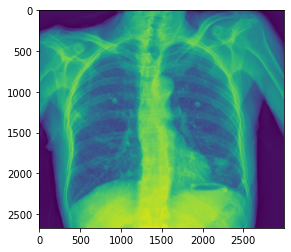

In [61]:
chest_xray_record = padchest_df[padchest_df["ImageID"] == padchest_masks.iloc[1]["ImageID"]]

Dir = chest_xray_record["ImageDir"].iloc[0]
Id = chest_xray_record["ImageID"].iloc[0]
path = f"/home/data_shares/purrlab/padchest/{Dir}/{Id}"

chest_xray = Image.open(path)

plt.imshow(np.asarray(chest_xray))
plt.show()

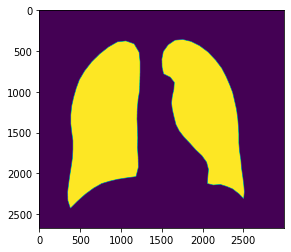

In [45]:
image = decode_both_lungs(padchest_masks.iloc[1])

plt.imshow(image)
plt.show()

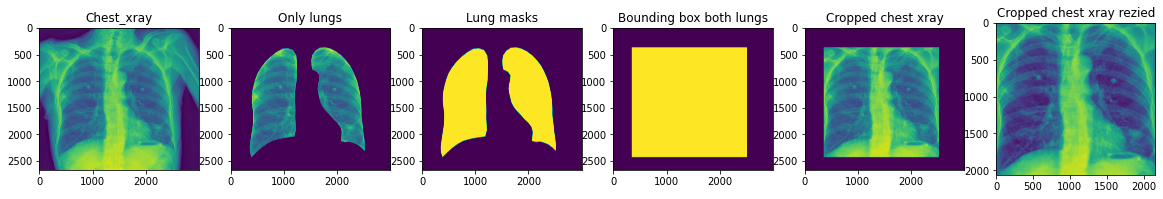

In [73]:
fig, axs = plt.subplots(1, 6, figsize=(20, 60))

axs[0].imshow(np.asarray(chest_xray))
axs[0].set_title("Chest_xray")
axs[2].imshow(image)
axs[2].set_title("Lung masks")
axs[1].imshow(only_lungs(chest_xray, image))
axs[1].set_title("Only lungs")
axs[3].imshow(bounding_box(image))
axs[3].set_title("Bounding box both lungs")
axs[4].imshow(only_lungs(chest_xray, bounding_box(image)))
axs[4].set_title("Cropped chest xray")
axs[5].imshow(np.asarray(crop_image(chest_xray, image)))
axs[5].set_title("Cropped chest xray rezied")
plt.show()

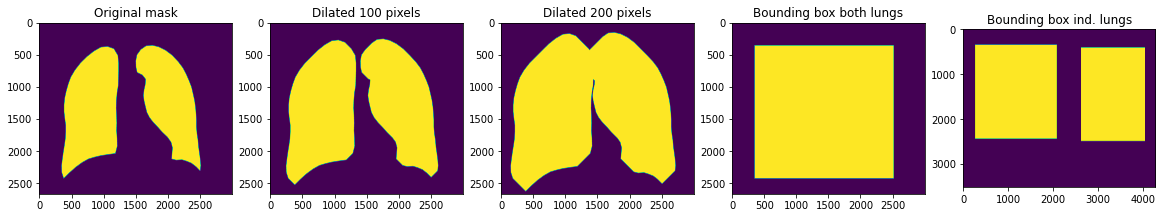

In [46]:

fig, axs = plt.subplots(1, 5, figsize=(20, 50))

axs[0].imshow(image)
axs[0].set_title("Original mask")
axs[1].imshow(fast_dilate(image, 100))
axs[1].set_title("Dilated 100 pixels")
axs[2].imshow(fast_dilate(image, 200))
axs[2].set_title("Dilated 200 pixels")
axs[3].imshow(bounding_box(image))
axs[3].set_title("Bounding box both lungs")
axs[4].imshow(bbox_both_lungs(padchest_masks.iloc[1]))
axs[4].set_title("Bounding box ind. lungs")
plt.show()

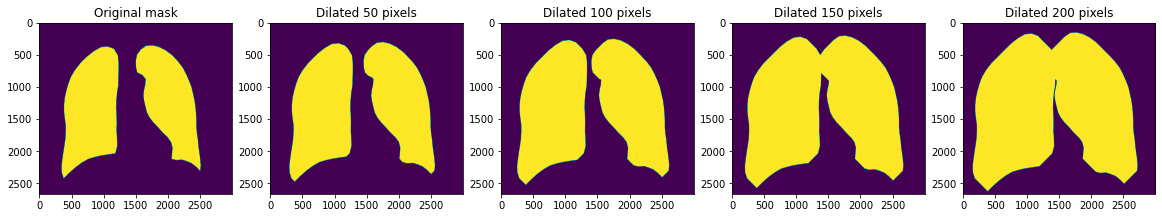

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(20, 50))

axs[0].imshow(image)
axs[0].set_title("Original mask")
axs[1].imshow(fast_dilate(image, 50))
axs[1].set_title("Dilated 50 pixels")
axs[2].imshow(fast_dilate(image, 100))
axs[2].set_title("Dilated 100 pixels")
axs[3].imshow(fast_dilate(image, 150))
axs[3].set_title("Dilated 150 pixels")
axs[4].imshow(fast_dilate(image, 200))
axs[4].set_title("Dilated 200 pixels")
plt.show()